In [1]:
import calendar
import os

import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

In [4]:
try:
    df = pd.read_csv(os.path.join("..", "data", "deaths_and_temps_england_wales.csv"))
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("deaths_and_temps_england_wales.csv"))

df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

# split into separate dataframes for pre and post onset of COVID-19
pre = df[df.index < "2020"]
post = df[df.index >= "2020"]

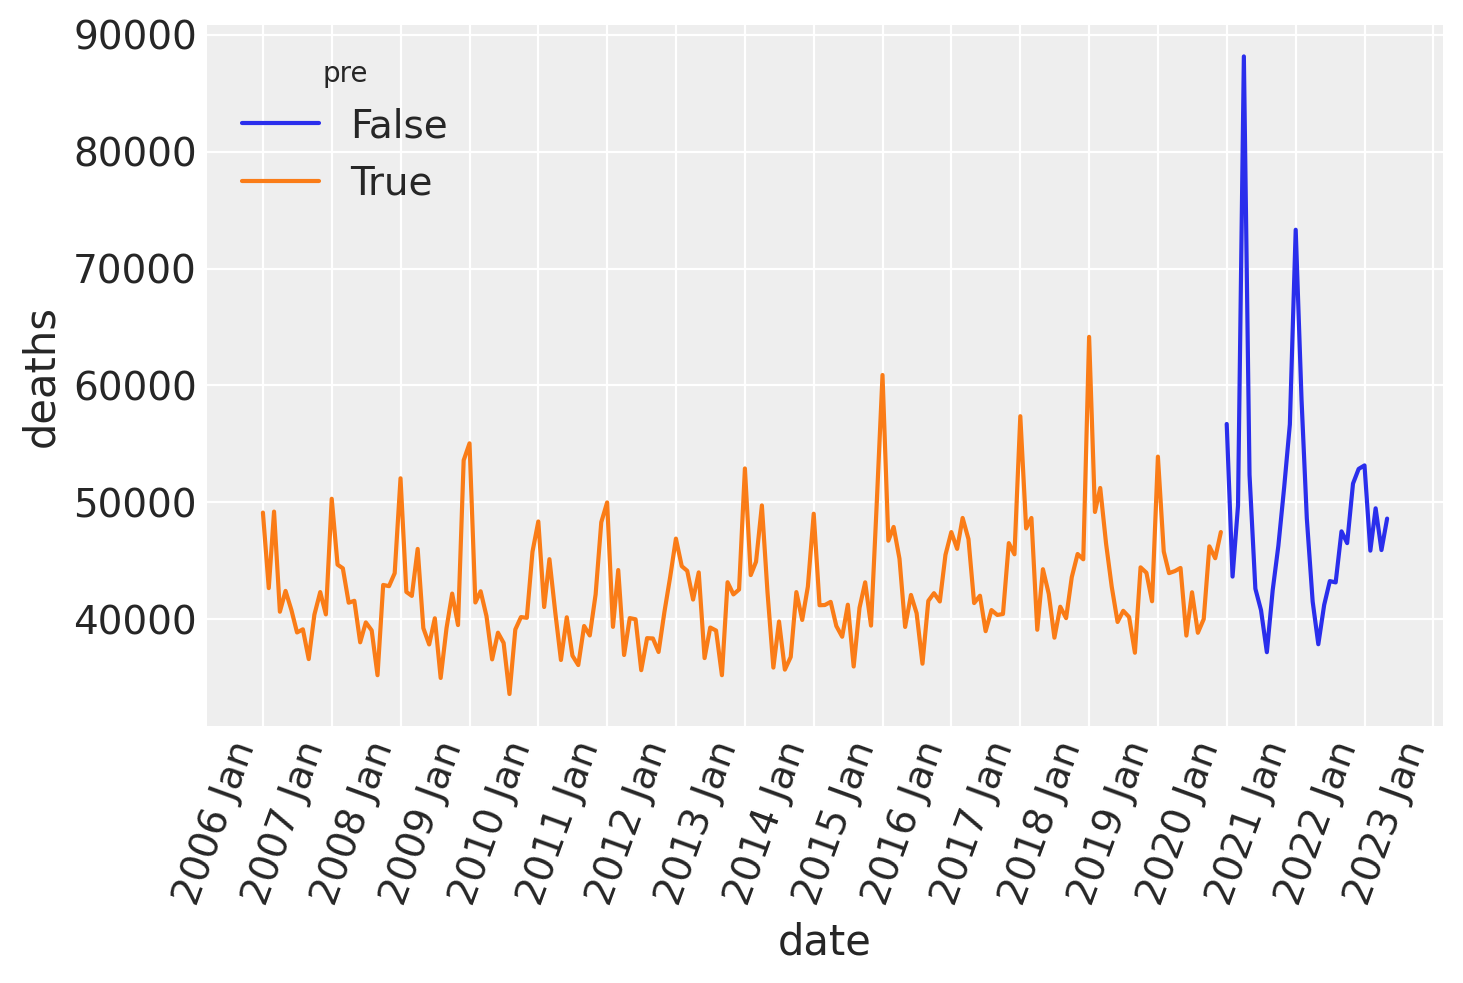

In [5]:
ax = sns.lineplot(data=df, x="date", y="deaths", hue="pre")
format_x_axis(ax)

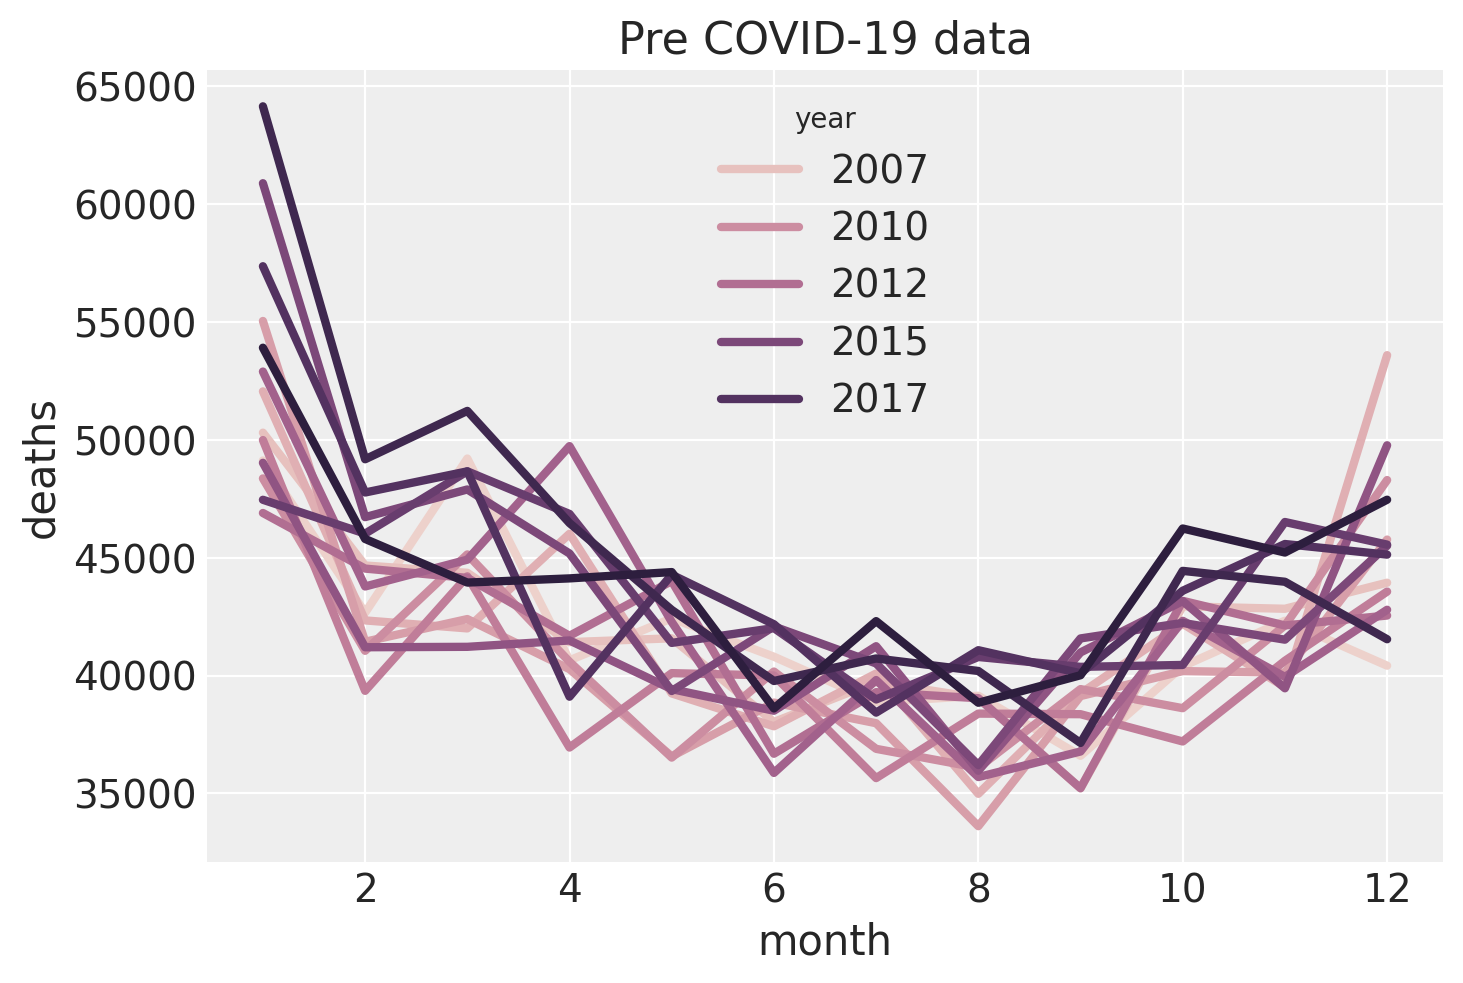

In [6]:
ax = sns.lineplot(data=pre, x="month", y="deaths", hue="year", lw=3)
ax.set(title="Pre COVID-19 data");

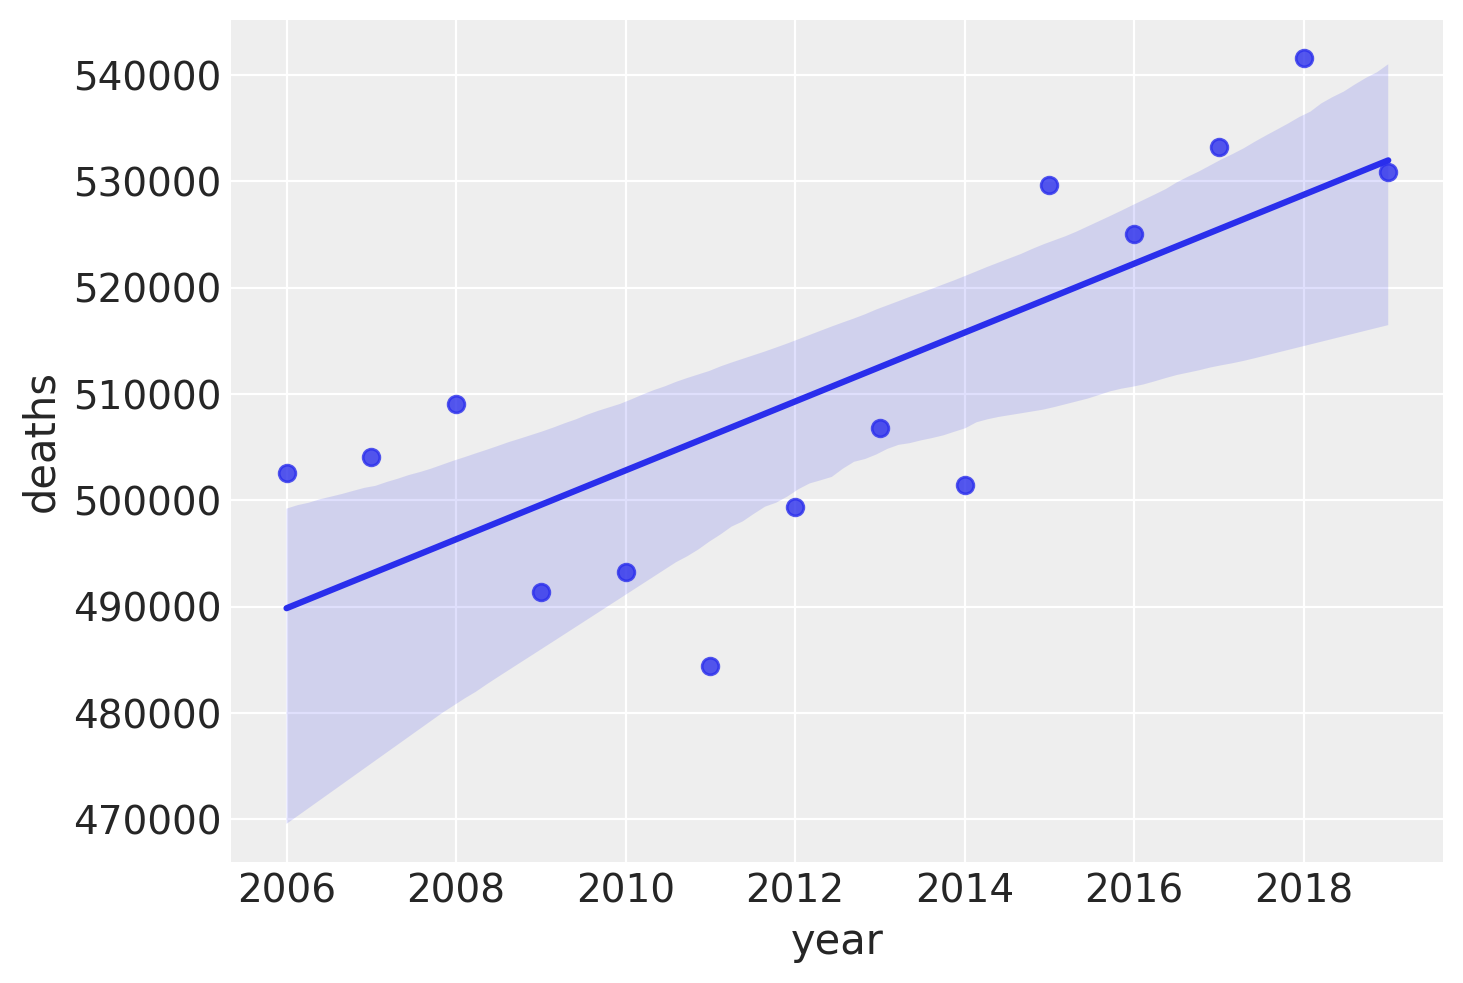

In [7]:
annual_deaths = pd.DataFrame(pre.groupby("year")["deaths"].sum()).reset_index()
sns.regplot(x="year", y="deaths", data=annual_deaths);

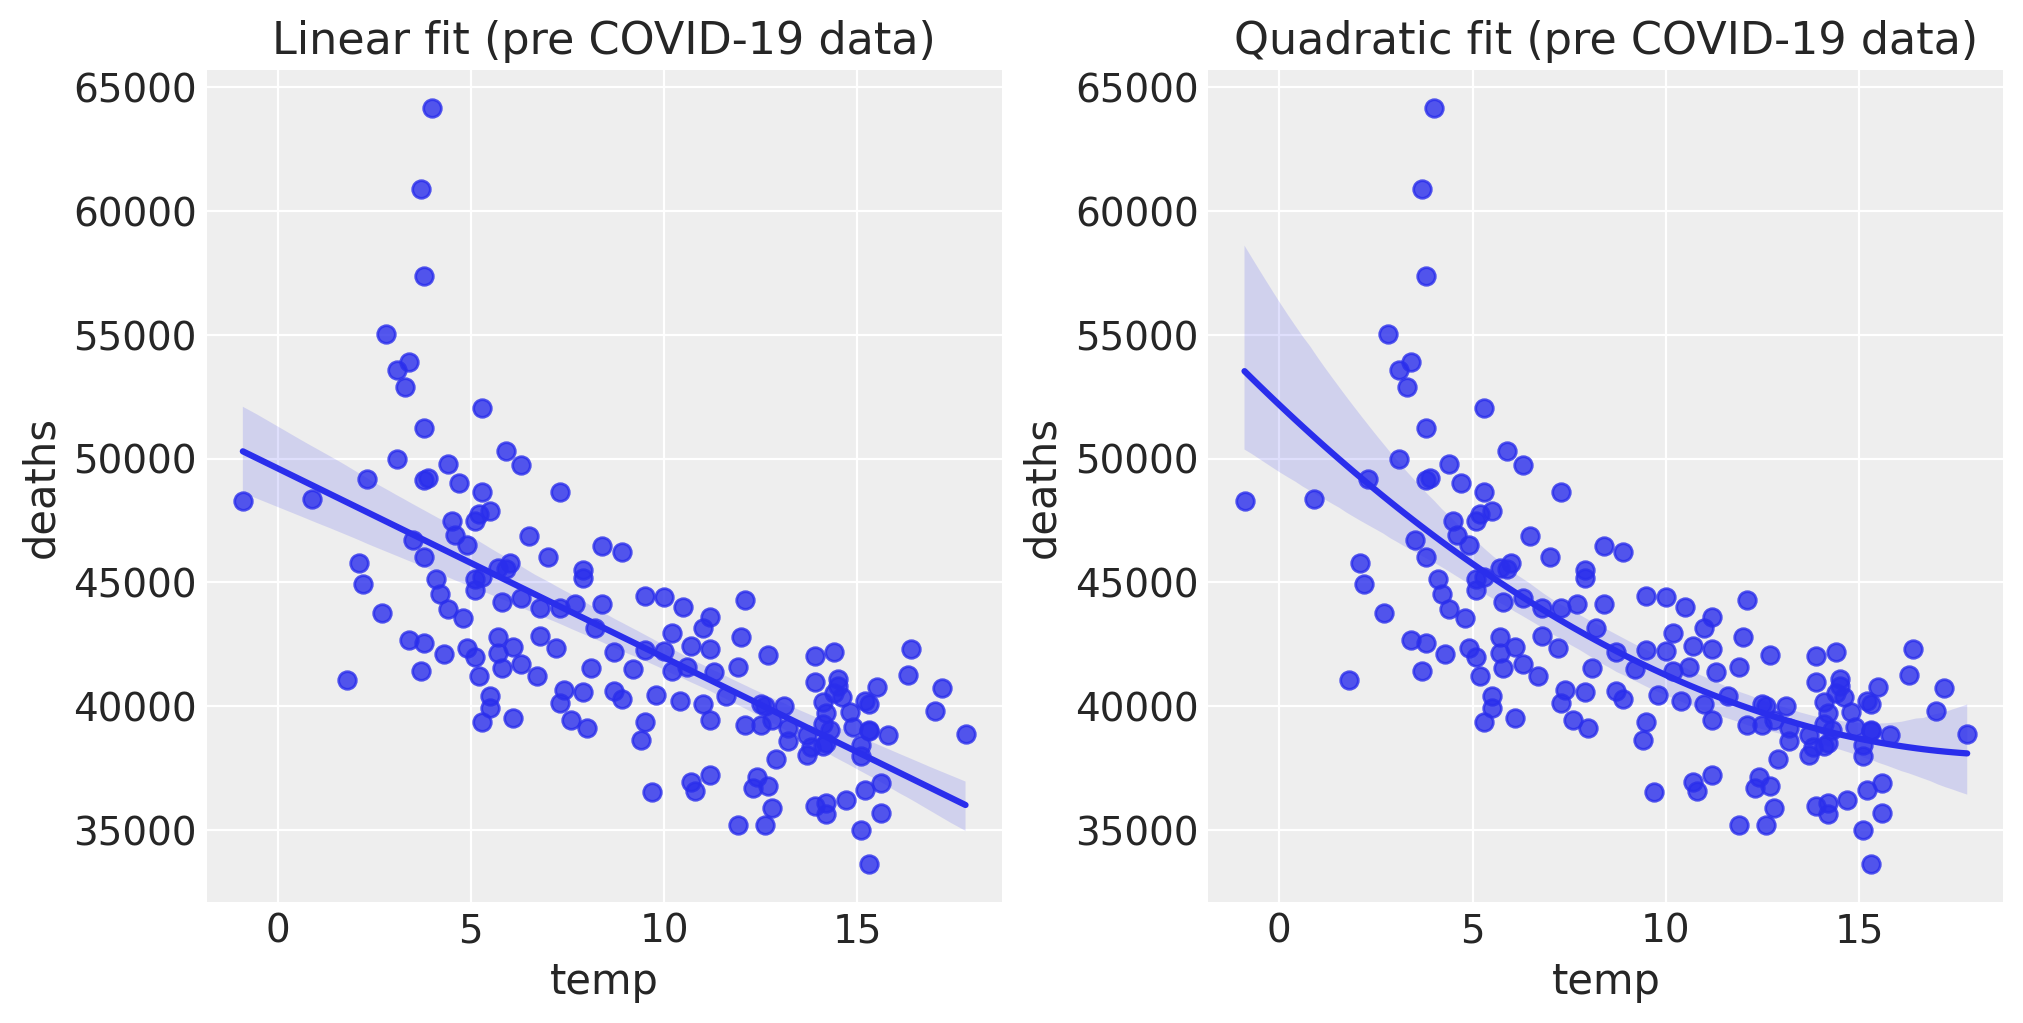

In [8]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=1, ax=ax[0])
ax[0].set(title="Linear fit (pre COVID-19 data)")
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=2, ax=ax[1])
ax[1].set(title="Quadratic fit (pre COVID-19 data)");

In [9]:
# NOTE: results are returned from higher to lower polynomial powers
slope, intercept = np.polyfit(pre["temp"], pre["deaths"], 1)
print(f"{slope:.0f} deaths/degree")

-764 deaths/degree


# Modeling

In [10]:
with pm.Model(coords={"month": month_strings}) as model:
    # observed predictors and outcome
    month = pm.MutableData("month", pre["month"].to_numpy(), dims="t")
    time = pm.MutableData("time", pre["t"].to_numpy(), dims="t")
    temp = pm.MutableData("temp", pre["temp"].to_numpy(), dims="t")
    deaths = pm.MutableData("deaths", pre["deaths"].to_numpy(), dims="t")

    # priors
    intercept = pm.Normal("intercept", 40_000, 10_000)
    month_mu = ZeroSumNormal("month mu", sigma=3000, dims="month")
    linear_trend = pm.TruncatedNormal("linear trend", 0, 50, lower=0)
    temp_coeff = pm.Normal("temp coeff", 0, 200)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) + month_mu[month - 1] + (temp_coeff * temp),
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 2_000)
    # likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=deaths, dims="t")

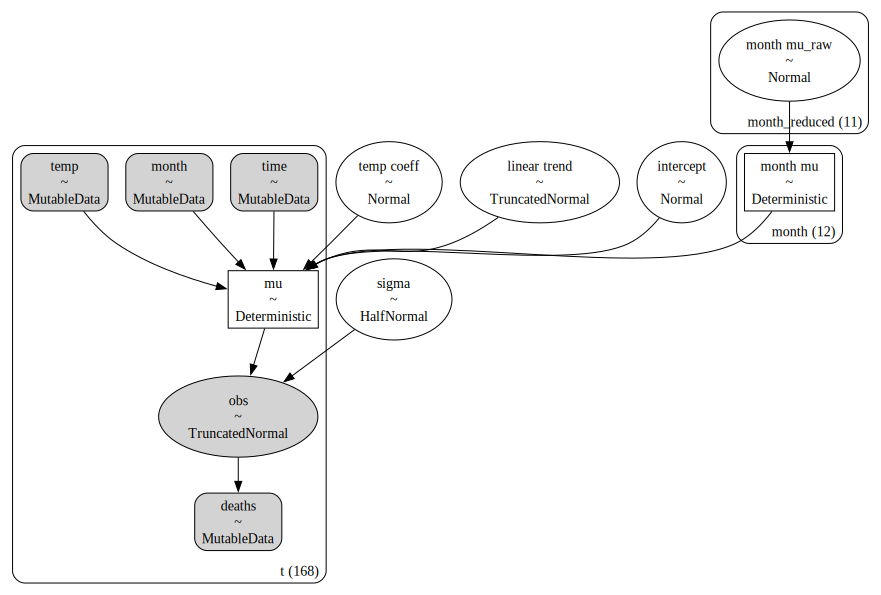

In [11]:
pm.model_to_graphviz(model)

In [47]:
import numpy as np
import torch as pt

value_example = pt.tensor([[1.0, 2.0, 6.0, 8.0, 2.0, 6.0, 8.0], [3.0, 4.0, 6.0, 8.0, 2.0, 6.0, 8.0]], dtype=pt.float32)
axis_example = 1

n_out = pt.tensor(value_example.shape[axis_example] + 1, dtype=pt.float32)
print("n_out (as tensor):", n_out)

sum_vals = value_example.sum(axis_example, keepdim=True)
print(value_example)
print("sum_vals:", sum_vals)
value_example.shape, sum_vals.shape

n_out (as tensor): tensor(8.)
tensor([[1., 2., 6., 8., 2., 6., 8.],
        [3., 4., 6., 8., 2., 6., 8.]])
sum_vals: tensor([[33.],
        [37.]])


(torch.Size([2, 7]), torch.Size([2, 1]))

In [48]:
print(pt.sqrt(n_out) + n_out)
norm = sum_vals / (pt.sqrt(n_out) + n_out)
print("norm:", norm)

fill_val = norm - (sum_vals / pt.sqrt(n_out))
print("fill_val:", fill_val)

out = pt.concatenate([value_example, fill_val], axis=axis_example)
print("Concatenated output (before normalization):", out)

final_output = out - norm
print("Final output (after normalization):", final_output)



tensor(10.8284)
norm: tensor([[3.0475],
        [3.4169]])
fill_val: tensor([[-8.6197],
        [-9.6645]])
Concatenated output (before normalization): tensor([[ 1.0000,  2.0000,  6.0000,  8.0000,  2.0000,  6.0000,  8.0000, -8.6197],
        [ 3.0000,  4.0000,  6.0000,  8.0000,  2.0000,  6.0000,  8.0000, -9.6645]])
Final output (after normalization): tensor([[ -2.0475,  -1.0475,   2.9525,   4.9525,  -1.0475,   2.9525,   4.9525,
         -11.6673],
        [ -0.4169,   0.5831,   2.5831,   4.5831,  -1.4169,   2.5831,   4.5831,
         -13.0815]])


In [49]:
final_output.sum(1, keepdim=True)

tensor([[0.],
        [0.]])

In [41]:
4**0.5

2.0

In [52]:
def f_n(n):
    n = n+1
    return 1 - (n - 1)/(n**0.5 + 1) - 1/n**0.5
for i in range(1, 10):
    print(f"{i}: ", f_n(i))

1:  -0.12132034355964261
2:  -0.30940107675850315
3:  -0.5
4:  -0.6832815729997475
5:  -0.8577380332470412
6:  -1.0237157840738176
7:  -1.1819805153394638
8:  -1.3333333333333333
9:  -1.478505426185217
